### Load Packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:08<00:00, 20750597.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
trainset.data.shape

(50000, 32, 32, 3)

In [9]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [11]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [12]:
def imshow(img):
  img = img / 2 + 0.5 # Unnormalize the data
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

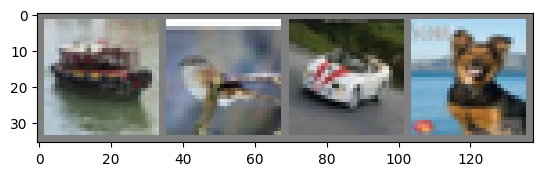

ship  bird  car   dog  


In [13]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Train Model

The forward pass returns both the prediction and the embeddings (120 long vector) from after the first fcl. These embeddings are used to train a KNN model.

In [14]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    embedding = x.clone()
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x, embedding

net = Net()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    optimizer.zero_grad()

    outputs, embeddings = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.246
[1,  4000] loss: 1.889
[1,  6000] loss: 1.704
[1,  8000] loss: 1.571
[1, 10000] loss: 1.530
[1, 12000] loss: 1.473
[2,  2000] loss: 1.408
[2,  4000] loss: 1.368
[2,  6000] loss: 1.350
[2,  8000] loss: 1.338
[2, 10000] loss: 1.314
[2, 12000] loss: 1.281
Finished Training


### Save Model and Train Embeddings

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [18]:
net = Net()
net.load_state_dict(torch.load(PATH))

all_embeddings = []
all_labels = []

with torch.no_grad():
  for images, labels in trainloader:
    pred, embeddings = net(images)
    all_embeddings.append(embeddings.numpy())
    all_labels.append(labels.numpy())

In [19]:
all_embeddings = np.concatenate(all_embeddings, axis=0)
embeddings = pd.DataFrame(data=all_embeddings)
embeddings

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,1.848216,0.0,0.0,1.511218,1.008995,0.756709,1.381102,0.0,0.000000,2.967237,...,0.000000,3.346827,2.144446,0.00000,1.762644,0.000000,0.000000,0.000000,1.841843,1.518200
1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.845629,0.000000,...,1.485051,0.000000,0.000000,0.00000,0.000000,0.000000,0.624286,0.639268,0.470947,0.000765
2,0.981987,0.0,0.0,0.000000,0.000000,0.000000,1.176223,0.0,0.000000,0.000000,...,0.000000,1.932449,1.365632,0.00000,0.276177,0.000000,0.000000,0.754018,1.969793,2.941083
3,0.567965,0.0,0.0,0.000000,1.533165,2.837154,0.000000,0.0,0.000000,0.521584,...,0.000000,2.220384,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.000000,0.000000,4.430304,1.477841,0.0,0.000000,2.021407,...,0.000000,0.000000,0.000000,0.00000,1.546105,0.000000,2.639175,0.000000,0.775621,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.0,0.0,0.000000,0.000000,0.000000,2.353452,0.0,0.000000,0.451569,...,0.000000,0.000000,0.000000,0.00000,1.226782,0.000000,0.000000,1.475859,0.000000,0.287457
49996,0.188957,0.0,0.0,0.000000,1.227177,0.000000,1.179050,0.0,0.000000,0.000000,...,0.000000,1.156274,1.879324,0.00000,0.000000,0.305516,0.000000,0.000000,1.593339,0.000000
49997,1.966174,0.0,0.0,0.000000,4.442869,3.619678,0.792558,0.0,0.000000,3.406183,...,0.000000,1.041166,2.474852,0.00000,0.992754,0.000000,0.000000,0.000000,0.000000,0.000000
49998,0.000000,0.0,0.0,0.000000,0.755898,0.000000,0.445255,0.0,0.816920,0.000000,...,0.059835,0.000000,0.000000,0.10248,0.000000,0.000000,0.000000,0.973887,0.000000,0.000000


In [20]:
all_labels = np.concatenate(all_labels, axis=0)
embeddings['label'] = all_labels
embeddings

train_embeddings = embeddings
train_embeddings

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,label
0,1.848216,0.0,0.0,1.511218,1.008995,0.756709,1.381102,0.0,0.000000,2.967237,...,3.346827,2.144446,0.00000,1.762644,0.000000,0.000000,0.000000,1.841843,1.518200,8
1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.845629,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.624286,0.639268,0.470947,0.000765,4
2,0.981987,0.0,0.0,0.000000,0.000000,0.000000,1.176223,0.0,0.000000,0.000000,...,1.932449,1.365632,0.00000,0.276177,0.000000,0.000000,0.754018,1.969793,2.941083,4
3,0.567965,0.0,0.0,0.000000,1.533165,2.837154,0.000000,0.0,0.000000,0.521584,...,2.220384,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.000000,0.0,0.0,0.000000,0.000000,4.430304,1.477841,0.0,0.000000,2.021407,...,0.000000,0.000000,0.00000,1.546105,0.000000,2.639175,0.000000,0.775621,0.000000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.0,0.0,0.000000,0.000000,0.000000,2.353452,0.0,0.000000,0.451569,...,0.000000,0.000000,0.00000,1.226782,0.000000,0.000000,1.475859,0.000000,0.287457,6
49996,0.188957,0.0,0.0,0.000000,1.227177,0.000000,1.179050,0.0,0.000000,0.000000,...,1.156274,1.879324,0.00000,0.000000,0.305516,0.000000,0.000000,1.593339,0.000000,3
49997,1.966174,0.0,0.0,0.000000,4.442869,3.619678,0.792558,0.0,0.000000,3.406183,...,1.041166,2.474852,0.00000,0.992754,0.000000,0.000000,0.000000,0.000000,0.000000,8
49998,0.000000,0.0,0.0,0.000000,0.755898,0.000000,0.445255,0.0,0.816920,0.000000,...,0.000000,0.000000,0.10248,0.000000,0.000000,0.000000,0.973887,0.000000,0.000000,4


### Test Model

This is testing the model purely using the CNN.

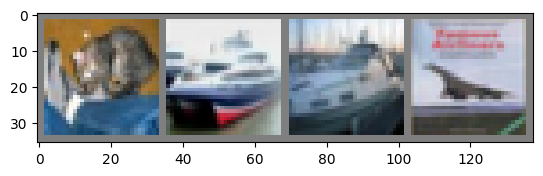

GroundTruth: cat   ship  ship  plane


In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [22]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [23]:
outputs, embeddings = net(images)

In [24]:
_, predicted = torch.max(outputs, 1)
print('Predicted:', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted: cat   ship  car   plane


In [25]:
correct = 0
total = 0

all_embeddings = []
all_labels = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs, embeddings = net(images)

    all_embeddings.append(embeddings.numpy())
    all_labels.append(labels.numpy())

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on 10000 test images: {100 * correct // total} %')

Accuracy of the network on 10000 test images: 52 %


In [27]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs, embeddings = net(images)
    _, predictions = torch.max(outputs, 1)

    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 53.5 %
Accuracy for class: car   is 85.4 %
Accuracy for class: bird  is 38.0 %
Accuracy for class: cat   is 31.5 %
Accuracy for class: deer  is 39.7 %
Accuracy for class: dog   is 37.2 %
Accuracy for class: frog  is 75.2 %
Accuracy for class: horse is 40.6 %
Accuracy for class: ship  is 70.5 %
Accuracy for class: truck is 54.6 %


Getting Test Embeddings

In [28]:
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
test_embeddings = pd.DataFrame(data=all_embeddings)
test_embeddings['label'] = all_labels
test_embeddings

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,label
0,0.0,0.000000,0.000000,0.0,0.000000,1.784912,2.575588,0.0,0.301404,0.425638,...,0.000000,0.167954,0.0,0.000000,0.302241,2.125553,0.000000,1.525395,0.166471,3
1,0.0,0.000000,0.000000,0.0,3.062053,3.215326,0.239929,0.0,0.000000,5.645954,...,2.696073,0.000000,0.0,2.523099,0.000000,0.000000,0.000000,0.000000,0.000000,8
2,0.0,0.000000,0.000000,0.0,2.319555,4.653955,1.339695,0.0,0.173020,3.199506,...,0.638868,0.110874,0.0,2.419102,0.000000,0.000000,0.000000,0.000000,0.000000,8
3,0.0,0.000000,0.000000,0.0,4.089005,3.775245,0.164134,0.0,0.295814,4.908000,...,0.959332,0.000000,0.0,1.608278,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.0,0.000000,0.117318,0.0,0.000000,0.000000,0.440299,0.0,0.929635,0.000000,...,0.000000,0.000000,0.0,0.360494,0.384041,1.591677,0.408761,0.000000,0.024826,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.000000,0.000000,0.0,0.000000,0.752623,0.608401,0.0,0.000000,0.000000,...,0.000000,0.602496,0.0,0.000000,5.306287,0.827851,0.000000,0.273424,0.000000,8
9996,0.0,1.166921,0.000000,0.0,0.000000,0.443028,0.377556,0.0,0.000000,0.164142,...,0.000000,0.000000,0.0,0.000000,0.000000,1.880766,0.000000,0.377777,0.945109,3
9997,0.0,0.564281,0.000000,0.0,0.000000,1.028661,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,2.379539,1.618334,0.000000,3.126655,0.266131,5
9998,0.0,0.000000,0.000000,0.0,0.000000,2.319239,0.000000,0.0,0.000000,2.829740,...,0.000000,0.000000,0.0,0.772155,0.000000,0.000000,0.406491,0.000000,0.000000,1


# CNN-KNN

In [29]:
train_embeddings

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,label
0,1.848216,0.0,0.0,1.511218,1.008995,0.756709,1.381102,0.0,0.000000,2.967237,...,3.346827,2.144446,0.00000,1.762644,0.000000,0.000000,0.000000,1.841843,1.518200,8
1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.845629,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.624286,0.639268,0.470947,0.000765,4
2,0.981987,0.0,0.0,0.000000,0.000000,0.000000,1.176223,0.0,0.000000,0.000000,...,1.932449,1.365632,0.00000,0.276177,0.000000,0.000000,0.754018,1.969793,2.941083,4
3,0.567965,0.0,0.0,0.000000,1.533165,2.837154,0.000000,0.0,0.000000,0.521584,...,2.220384,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.000000,0.0,0.0,0.000000,0.000000,4.430304,1.477841,0.0,0.000000,2.021407,...,0.000000,0.000000,0.00000,1.546105,0.000000,2.639175,0.000000,0.775621,0.000000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.0,0.0,0.000000,0.000000,0.000000,2.353452,0.0,0.000000,0.451569,...,0.000000,0.000000,0.00000,1.226782,0.000000,0.000000,1.475859,0.000000,0.287457,6
49996,0.188957,0.0,0.0,0.000000,1.227177,0.000000,1.179050,0.0,0.000000,0.000000,...,1.156274,1.879324,0.00000,0.000000,0.305516,0.000000,0.000000,1.593339,0.000000,3
49997,1.966174,0.0,0.0,0.000000,4.442869,3.619678,0.792558,0.0,0.000000,3.406183,...,1.041166,2.474852,0.00000,0.992754,0.000000,0.000000,0.000000,0.000000,0.000000,8
49998,0.000000,0.0,0.0,0.000000,0.755898,0.000000,0.445255,0.0,0.816920,0.000000,...,0.000000,0.000000,0.10248,0.000000,0.000000,0.000000,0.973887,0.000000,0.000000,4


In [30]:
test_embeddings

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,label
0,0.0,0.000000,0.000000,0.0,0.000000,1.784912,2.575588,0.0,0.301404,0.425638,...,0.000000,0.167954,0.0,0.000000,0.302241,2.125553,0.000000,1.525395,0.166471,3
1,0.0,0.000000,0.000000,0.0,3.062053,3.215326,0.239929,0.0,0.000000,5.645954,...,2.696073,0.000000,0.0,2.523099,0.000000,0.000000,0.000000,0.000000,0.000000,8
2,0.0,0.000000,0.000000,0.0,2.319555,4.653955,1.339695,0.0,0.173020,3.199506,...,0.638868,0.110874,0.0,2.419102,0.000000,0.000000,0.000000,0.000000,0.000000,8
3,0.0,0.000000,0.000000,0.0,4.089005,3.775245,0.164134,0.0,0.295814,4.908000,...,0.959332,0.000000,0.0,1.608278,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,0.0,0.000000,0.117318,0.0,0.000000,0.000000,0.440299,0.0,0.929635,0.000000,...,0.000000,0.000000,0.0,0.360494,0.384041,1.591677,0.408761,0.000000,0.024826,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.000000,0.000000,0.0,0.000000,0.752623,0.608401,0.0,0.000000,0.000000,...,0.000000,0.602496,0.0,0.000000,5.306287,0.827851,0.000000,0.273424,0.000000,8
9996,0.0,1.166921,0.000000,0.0,0.000000,0.443028,0.377556,0.0,0.000000,0.164142,...,0.000000,0.000000,0.0,0.000000,0.000000,1.880766,0.000000,0.377777,0.945109,3
9997,0.0,0.564281,0.000000,0.0,0.000000,1.028661,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,2.379539,1.618334,0.000000,3.126655,0.266131,5
9998,0.0,0.000000,0.000000,0.0,0.000000,2.319239,0.000000,0.0,0.000000,2.829740,...,0.000000,0.000000,0.0,0.772155,0.000000,0.000000,0.406491,0.000000,0.000000,1


In [31]:
X_train = train_embeddings.iloc[:, :-1].values
y_train = train_embeddings.iloc[:, -1].values

X_test = test_embeddings.iloc[:, :-1].values
y_test = test_embeddings.iloc[:, -1].values

In [32]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [33]:
preds = knn.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy of the network on 10000 test images: {accuracy} %')

Accuracy of the network on 10000 test images: 0.5531 %


In [34]:
knn_55 = KNeighborsClassifier(n_neighbors=55)
knn_55.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=55)

In [35]:
preds = knn_55.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy of the network on 10000 test images: {accuracy} %')

Accuracy of the network on 10000 test images: 0.5686 %


### PCA

In [45]:
def plot_PCA(X, classes, title):
  labels = np.unique(X['label'])
  for label in labels:
    plt.scatter(X[X['label'] == label]['x'],
                X[X['label'] == label]['y'],
                label=classes[label], alpha=0.7, s=10)
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.title(title)
  plt.legend()

In [46]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

X_train_reduced = pd.DataFrame(data=X_train_reduced, columns=['x', 'y'])
X_train_reduced['label'] = y_train

X_test_reduced = pd.DataFrame(data=X_test_reduced, columns=['x', 'y'])
X_test_reduced['label'] = y_test
X_test_reduced['pred'] = preds

pca.explained_variance_

array([15.706487,  8.480607], dtype=float32)

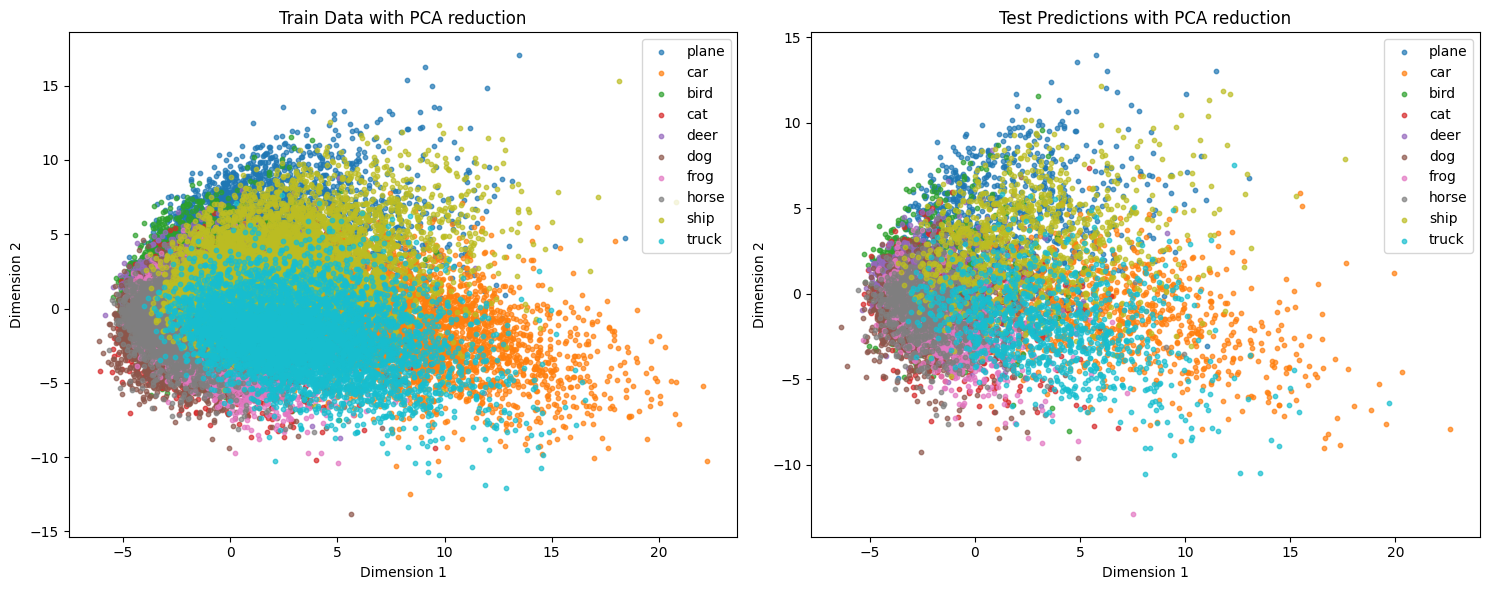

In [47]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_PCA(X_train_reduced, classes, 'Train Data with PCA reduction')

plt.subplot(1, 2, 2)
plot_PCA(X_test_reduced, classes, 'Test Predictions with PCA reduction')

plt.tight_layout()
plt.show()

In [48]:
train_embeddings.to_csv('train_embeddings.csv', index=False)
test_embeddings.to_csv('test_embeddings.csv', index=False)
X_train_reduced.to_csv('train_reduced.csv', index=False)
X_test_reduced.to_csv('test_reduced.csv', index=False)